# 예지 보수 Predictive Maintenance (PM)

- 보수의 종류
  > 고장 후 보수: 기기가 고장이 나면 보수를 하는 것   
  > 정기적인 보수: 일정한 시간 간격으로 보수를 하는 것    
  > 예지 보수: 고장을 예측하여 적절한 시점에 보수를 하는 것    
- 예제
 - 항공기 엔진 고장 시점 및 일정 기간내 고장발생 여부 예측

## PM 회귀 모델
- TTF(time to fail): 고장까지 남은 시간을 예측하는 회귀 모델로 구현
<img src="https://github.com/data-labs/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-02-15%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%2010.02.12.png?raw=1" align='left'>

## PM 분류 모델 (이진 분류)
- U (Unsafe): TTF가 주어진 경계치 이하로 낮은 위험한 상태
- U 값이 0/1을 갖는 이진 분류 모델로 구현
<img src="https://github.com/data-labs/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-02-15%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%2010.03.35.png?raw=1" align='left'>

## PM 분류 모델 (다중  분류)
- U (Unsafe): 위험한 상태를 2개 이상으로 분류
- U 값이 0/1/2 세가지를 갖는 다중 분류 모델로 구현

<img src="https://github.com/data-labs/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-02-15%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%2010.45.50.png?raw=1" align='left'>

## 기본 라이브러리

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

## 훈련 데이터
- 스페이스로 구분된 숫자 원시 (raw) 데이터를 데이터프레임으로 읽는다
- 매 사이클별로 항공기 엔진 운영 상태(State) 제공
- 엔진별, 고장 시점까지의 운영 데이터 제공

In [8]:
path = 'http://azuremlsamples.azureml.net/templatedata/PM_train.txt'
data_raw = pd.read_csv(path, sep = ' ', header=None)
print(data_raw.shape)
data_raw[:3]

(20631, 28)


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN


### 컬럼 이름은 미리 주어져 있다

In [10]:
col_names = ['id','cycle','setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

- 컬럼 (변수) 설명
 -	__id__: 엔진 ID (1~100)
 -	__cycle__: 엔진별 운행 시퀀스 번호, (1~ 고장시점 까지)
 -	__setting1__ to __setting3__: 엔진 운영 설정 변수
 -	__s1__ to __s21__: 센서 값


In [11]:
# 불필요한 컬럼 삭제 (마지막 두 컬럼)
data_raw.drop([26,27], axis=1, inplace=True)

In [12]:
# 컬럼 이름 변경
data_raw.columns = col_names
data_raw[185:195] 
# 엔진 1에서 엔진 2 데이터로 바뀌는 부분이 192행이다

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
185,1,186,0.0027,-0.0003,100.0,518.67,643.51,1595.16,1426.30,14.62,...,520.08,2388.25,8123.45,8.5227,0.03,397,2388,100.0,38.47,23.0564
186,1,187,-0.0047,-0.0000,100.0,518.67,643.32,1592.10,1427.27,14.62,...,519.53,2388.28,8115.67,8.5218,0.03,396,2388,100.0,38.42,23.0822
187,1,188,-0.0067,0.0003,100.0,518.67,643.75,1602.38,1422.78,14.62,...,519.79,2388.23,8117.69,8.5207,0.03,396,2388,100.0,38.51,22.9588
188,1,189,-0.0006,0.0002,100.0,518.67,644.18,1596.17,1428.01,14.62,...,519.58,2388.33,8117.51,8.5183,0.03,395,2388,100.0,38.48,23.1127
189,1,190,-0.0027,0.0001,100.0,518.67,643.64,1599.22,1425.95,14.62,...,520.04,2388.35,8112.58,8.5223,0.03,398,2388,100.0,38.49,23.0675
190,1,191,-0.0000,-0.0004,100.0,518.67,643.34,1602.36,1425.77,14.62,...,519.57,2388.30,8114.61,8.5174,0.03,394,2388,100.0,38.45,23.1295
191,1,192,0.0009,-0.0000,100.0,518.67,643.54,1601.41,1427.20,14.62,...,520.08,2388.32,8110.93,8.5113,0.03,396,2388,100.0,38.48,22.9649
192,2,1,-0.0018,0.0006,100.0,518.67,641.89,1583.84,1391.28,14.62,...,522.33,2388.06,8137.72,8.3905,0.03,391,2388,100.0,38.94,23.4585
193,2,2,0.0043,-0.0003,100.0,518.67,641.82,1587.05,1393.13,14.62,...,522.70,2387.98,8131.09,8.4167,0.03,392,2388,100.0,39.06,23.4085
194,2,3,0.0018,0.0003,100.0,518.67,641.55,1588.32,1398.96,14.62,...,522.58,2387.99,8140.58,8.3802,0.03,391,2388,100.0,39.11,23.4250


- 100개의 엔진이 있고 각각 1~362 사이클 실행 정보가 있다.
- 마지막 사이클 번호가 고장난 시점이다.

# 레이블(y) 컬럼 생성
- 회귀 분석에서는 잔여시간(TTF)을 추정하며 각 상태(State)에서 앞으로 남은 잔여시간을 계산한 후 이를 예측하는 회귀 모델을 만든다
- 분류 분석에서는 앞으로 얼마 기간 이내에 고장 날지 여부를 예측한다
    - 이진 분류: 예를 들어 30 사이클 이내에 고장 여부를 분류한다 (0/1 구분)
    - 다중 분류: 예를 들어 30 사이클 이내에 고장이 날지 또는 15 사이클 이내 고장이 날지를 나누어 예측한다 (0/1/2 구분)
- 회귀 및 분류를 위한 레이블을 만들겠다

## 데이터 사본 저장

In [13]:
df = data_raw.copy()

### TTF 구하기
- TTF를 RUL(Remaining Useful Life)라고도 한다
- 잔여수명 (RUL) 컬럼 추가
- 같은 엔진 ID에 대해서 최대값이 "수명"을 나타내므로 이를 먼저 구하고
- 이를 rul 데이터프레임에 저장한다. RUL은 Remaining Useful Lifetime
- 같은 'id'를 같는 행들을 하나의 데이터프레임으로 만드는 groupby를 사용한다

In [94]:
rul = pd.DataFrame(df.groupby('id')['cycle'].max()).reset_index()
rul

,id,cycle
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269
...,...,...
95,96,336
96,97,202
97,98,156
98,99,185


- 각 행별로 ttf 값은, 각 엔진별 rul 테이블의 수명에서 현재 시점 cycle 값을 뺀 값이다
- rul 데이터프레임에서 수명을 나타내는 cycle 컬럼 이름을 max라고 바꾸겠다
- 잔여 수명을 나타내는 'ttf' 컬럼을 추가한다

In [95]:
rul.columns = ['id', 'max']
df = df.merge(rul, on=['id'], how='left')
df[:10]

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s18,s19,s20,s21,max_x,max_y,ttf,label_bnc,label_mcc,max
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.0,0.713178,0.724662,0.273504,0.273504,191,0,0,192
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.0,0.666667,0.731014,0.273504,0.273504,190,0,0,192
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.0,0.627907,0.621375,0.273504,0.273504,189,0,0,192
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.0,0.573643,0.662386,0.273504,0.273504,188,0,0,192
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.0,0.589147,0.704502,0.273504,0.273504,187,0,0,192
5,1,6,0.252874,0.416667,0.0,0.0,0.268072,0.292784,0.272113,0.0,...,0.0,0.0,0.651163,0.652720,0.273504,0.273504,186,0,0,192
6,1,7,0.557471,0.583333,0.0,0.0,0.382530,0.463920,0.261985,0.0,...,0.0,0.0,0.744186,0.667219,0.273504,0.273504,185,0,0,192
7,1,8,0.304598,0.750000,0.0,0.0,0.406627,0.259865,0.316003,0.0,...,0.0,0.0,0.643411,0.574979,0.273504,0.273504,184,0,0,192
8,1,9,0.545977,0.583333,0.0,0.0,0.274096,0.434707,0.211850,0.0,...,0.0,0.0,0.705426,0.707539,0.273504,0.273504,183,0,0,192
9,1,10,0.310345,0.583333,0.0,0.0,0.150602,0.440375,0.307394,0.0,...,0.0,0.0,0.627907,0.794256,0.273504,0.273504,182,0,0,192


In [96]:
df['ttf'] = df['max'] - df['cycle']
df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s18,s19,s20,s21,max_x,max_y,ttf,label_bnc,label_mcc,max
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.0,0.713178,0.724662,0.273504,0.273504,191,0,0,192
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.0,0.666667,0.731014,0.273504,0.273504,190,0,0,192
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.0,0.627907,0.621375,0.273504,0.273504,189,0,0,192
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.0,0.573643,0.662386,0.273504,0.273504,188,0,0,192
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.0,0.589147,0.704502,0.273504,0.273504,187,0,0,192


In [97]:
df.drop('max', axis=1, inplace=True)

### 분류용 레이블
- 이진분류를 위해서, 앞으로 30 사이클 이내에 고장이 날 지를 예측하는 이진 분류용 레이블을 만든다
 - bnc (binary classifiation)
- 다중 분류를 위해서, 앞으로 30 및 15 사이클 이내에 고장이 날 지를 구분하는 다중 분류용 레이블을 만든다
 - mcc (multi-class classification)

In [99]:
w1 = 30
w2 = 15
df['label_bnc'] = np.where(df['ttf'] <= w1, 1, 0 )      # 2진 분류용
df['label_mcc'] = df['label_bnc']                       # 3진 분류용
df.loc[df['ttf'] <= w2, 'label_mcc'] = 2
df[:5]

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s17,s18,s19,s20,s21,max_x,max_y,ttf,label_bnc,label_mcc
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.333333,0.0,0.0,0.713178,0.724662,0.273504,0.273504,191,0,0
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.333333,0.0,0.0,0.666667,0.731014,0.273504,0.273504,190,0,0
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.166667,0.0,0.0,0.627907,0.621375,0.273504,0.273504,189,0,0
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.333333,0.0,0.0,0.573643,0.662386,0.273504,0.273504,188,0,0
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.416667,0.0,0.0,0.589147,0.704502,0.273504,0.273504,187,0,0


In [100]:
df[173:193]

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s17,s18,s19,s20,s21,max_x,max_y,ttf,label_bnc,label_mcc
173,1,174,0.494253,0.333333,0.0,0.0,0.430723,0.627207,0.680790,0.0,...,0.416667,0.0,0.0,0.333333,0.195388,0.273504,0.273504,18,1,1
174,1,175,0.505747,0.666667,0.0,0.0,0.722892,0.703074,0.679777,0.0,...,0.500000,0.0,0.0,0.341085,0.363297,0.273504,0.273504,17,1,1
175,1,176,0.385057,0.250000,0.0,0.0,0.496988,0.462830,0.683322,0.0,...,0.500000,0.0,0.0,0.449612,0.490058,0.273504,0.273504,16,1,1
176,1,177,0.281609,0.250000,0.0,0.0,0.777108,0.675387,0.704591,0.0,...,0.666667,0.0,0.0,0.379845,0.377106,0.273504,0.273504,15,1,2
177,1,178,0.494253,0.666667,0.0,0.0,0.653614,0.747547,0.715733,0.0,...,0.583333,0.0,0.0,0.395349,0.390500,0.273504,0.273504,14,1,2
178,1,179,0.632184,0.250000,0.0,0.0,0.496988,0.469152,0.796759,0.0,...,0.583333,0.0,0.0,0.488372,0.406794,0.273504,0.273504,13,1,2
179,1,180,0.362069,0.500000,0.0,0.0,0.713855,0.628515,0.588960,0.0,...,0.583333,0.0,0.0,0.558140,0.155758,0.273504,0.273504,12,1,2
180,1,181,0.465517,0.916667,0.0,0.0,0.671687,0.559625,0.648042,0.0,...,0.750000,0.0,0.0,0.155039,0.374206,0.273504,0.273504,11,1,2
181,1,182,0.442529,0.750000,0.0,0.0,0.903614,0.676695,0.748987,0.0,...,0.750000,0.0,0.0,0.224806,0.392847,0.273504,0.273504,10,1,2
182,1,183,0.505747,0.583333,0.0,0.0,0.611446,0.570961,0.620864,0.0,...,0.666667,0.0,0.0,0.325581,0.325877,0.273504,0.273504,9,1,2


## 스케일링
- 모든 센서 값의 최소, 최대 값이 0~1 범위를 갖도록 스케일링한다 
- 스케일링 대상이 아닌 ['id','cycle','ttf','label_bnc','label_mcc'] 컬럼은 제외하기 위해서 difference 함수를 사용한다

In [101]:
# Min-Max scaling
from sklearn.preprocessing import MinMaxScaler
cols_sc = df.columns.difference(['id','cycle','ttf','label_bnc','label_mcc'])
min_max_scaler = MinMaxScaler()
df[cols_sc] = min_max_scaler.fit_transform(df[cols_sc])
df[:3]

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s17,s18,s19,s20,s21,max_x,max_y,ttf,label_bnc,label_mcc
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.333333,0.0,0.0,0.713178,0.724662,0.273504,0.273504,191,0,0
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.333333,0.0,0.0,0.666667,0.731014,0.273504,0.273504,190,0,0
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.166667,0.0,0.0,0.627907,0.621375,0.273504,0.273504,189,0,0


# 탐색적 분석
-  전처리된 데이터를 파일에서 읽는다

In [102]:
# 모델 입력(X)으로 사용할 특성을 선택한다 (여기서는 모두 사용)
features = ['setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

In [103]:
# ttf와 상관관계가 큰 순으로 소팅해 본다
df[features].corrwith(df.ttf).sort_values(ascending=False)

s12         0.671983
s7          0.657223
s21         0.635662
s20         0.629428
setting2   -0.001948
setting1   -0.003198
s6         -0.128348
s14        -0.306769
s9         -0.390102
s13        -0.562569
s8         -0.563968
s3         -0.584520
s17        -0.606154
s2         -0.606484
s15        -0.642667
s4         -0.678948
s11        -0.696228
setting3         NaN
s1               NaN
s5               NaN
s10              NaN
s16              NaN
s18              NaN
s19              NaN
dtype: float64

In [104]:
# ttf와의 상관관계가 큰 특성의 리스트
corr_big_features = ['s12', 's7', 's21', 's20', 's6', 's14', 
    's9', 's13', 's8', 's3', 's17', 's2', 's15', 's4', 's11']

## 상관관계 히트맵

In [105]:
corr_big_features = corr_big_features +  ['ttf']

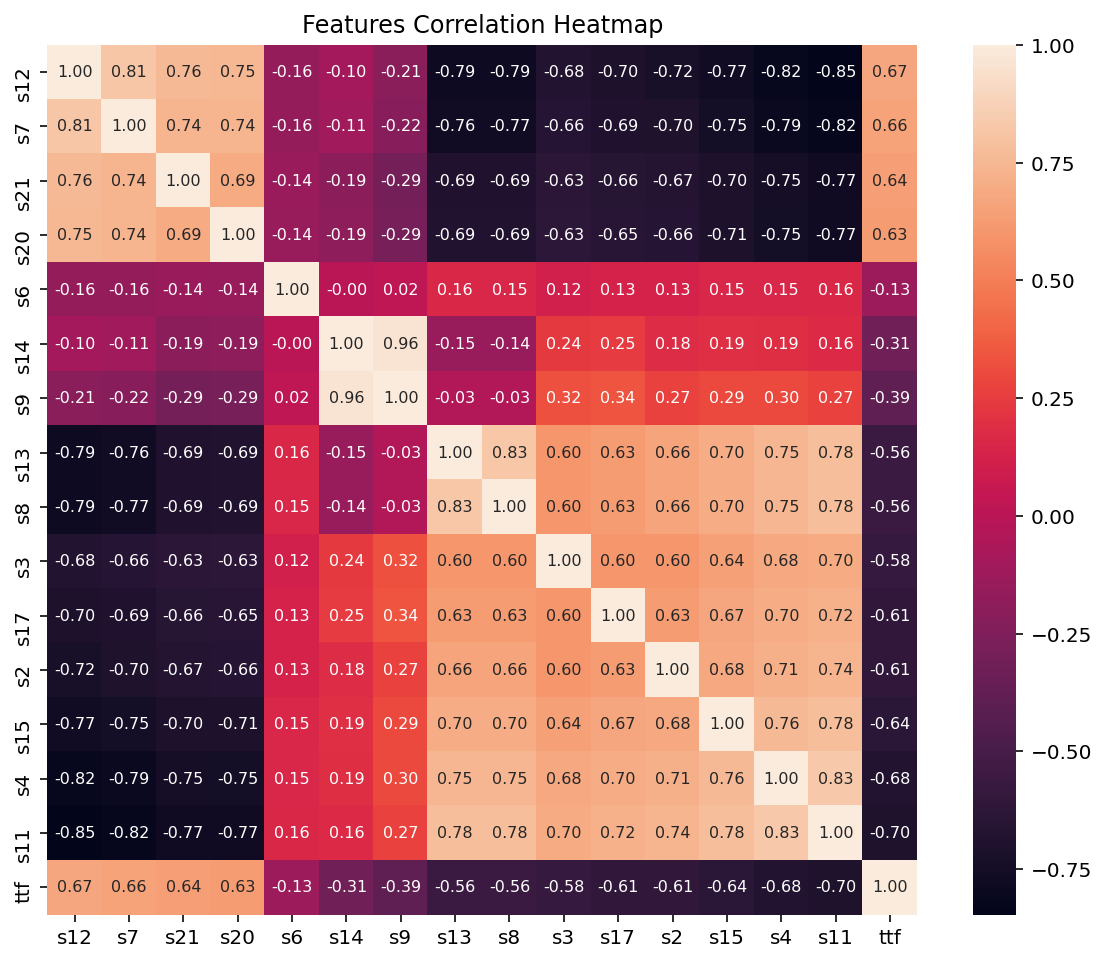

In [106]:
import seaborn as sns
cm = np.corrcoef(df[corr_big_features].values.T)
# sns.set(font_scale=1.0)
fig = plt.figure(figsize=(10, 8))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', 
  annot_kws={'size': 8}, yticklabels=corr_big_features, 
                 xticklabels=corr_big_features)
plt.title('Features Correlation Heatmap')
plt.show()

- 높은 상관관계를 갖는 특성들(> 0.8): (s14, s9), (s11, s4), (s11, s7), (s11, s12), (s4, s12), (s8,s13),  (s7, s12)  
- 이들은 중복 성향이 있어 제거 대상이 될 수 있다.

# 시각화
- 여러 특성의 분포를 파악하는 함수를 정의한다
- 센서 s에 대해서 랜덤하게 선택한 N개의 엔진 데이터 보기

## 시간에 따른 센서값 변화 보기
- 센서 s에 대해서 랜덤하게 선택한 N개의 엔진 데이터 보기

In [107]:
def plot_time_series(df, s, N):    
    fig, axes = plt.subplots(N, 1, sharex=True, figsize = (8, 8))
    fig.suptitle(s + ' time series / cycle', fontsize=12)
    
    select_engines = np.random.choice(range(1,101), N, replace=False).tolist()
    
    for e_id in select_engines:
        df2 = df[['cycle', s]][df.id == e_id]
        i = select_engines.index(e_id)
        axes[i].plot(df2['cycle'],df2[s])
        axes[i].set_ylabel('engine ' + str(e_id))
        axes[i].set_xlabel('cycle')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

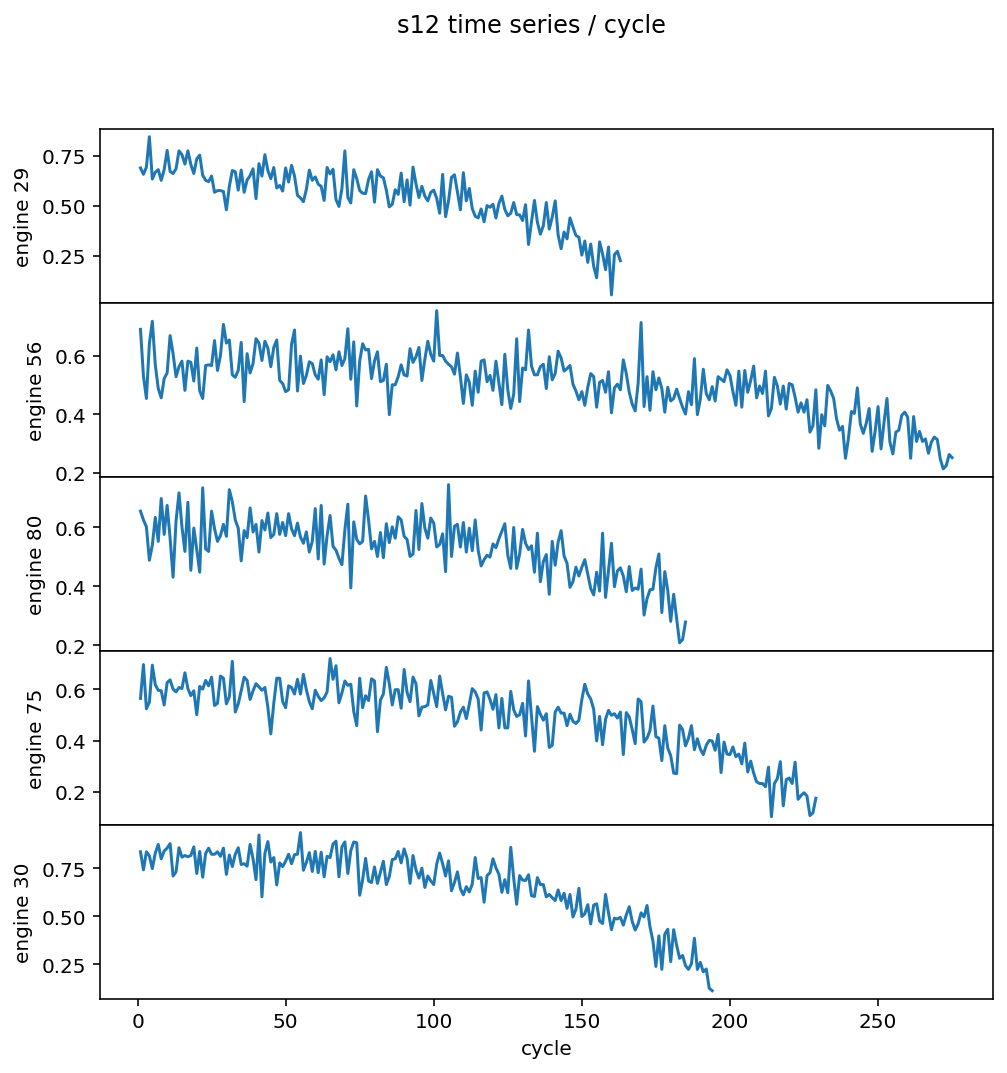

In [21]:
plot_time_series(df, 's12',5)

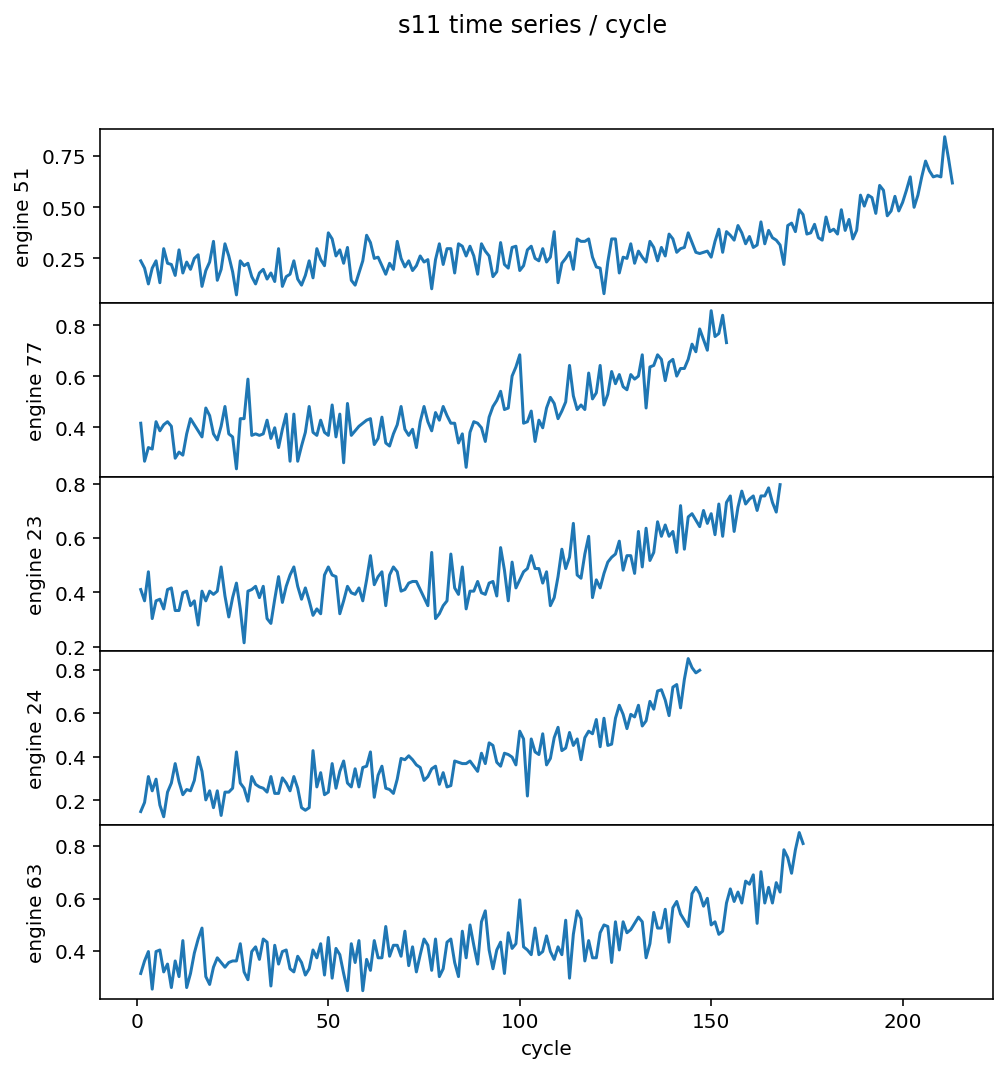

In [108]:
plot_time_series(df, 's11',5)

# 고장시점 예측
- 회귀분석

## 입력(X)과 레이블(y) 설정

In [109]:
# features = ['s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']
X = df[features]
y = df['ttf']

## 훈련데이터 검증 데이터 나누기

In [110]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15473, 24), (5158, 24), (15473,), (5158,))

# 회귀분석 성능 지표
- 대표적인 성능 측정 지표 보기
 - RMSE
 - MAE
 - R squared

In [111]:
def show_regression_result(y_test, y_pred, N=100):
    y_test = y_test.values
    plt.rc('figure', figsize=(6,4))
    error = y_pred - y_test
    print("MAE=", np.abs(error).mean().round(4))
    print("rmse=", np.sqrt((error**2).mean()).round(4))
    print("max error=", max(error).round(4))
    print("R2=",r2_score(y_test, y_pred).round(4)) # R2
    plt.plot(y_test[:N], 'r.-', label='y_test')
    plt.plot(y_pred[:N], 'b.-', label='y_pred')
    plt.legend()
    plt.show()
    plt.scatter(y_test, error, s=5)
    plt.xlabel('y_test')
    plt.ylabel('error')
    plt.show()

## 상관 계수와 중요 특성값

In [112]:
def plot_features_weights(features, weights):
    W = pd.DataFrame({'Weights':weights}, features)
    W.sort_values(by='Weights', ascending=True).plot(kind='barh', color='r', figsize=(8,6))
    plt.xlabel('Features Importance/Weights')
    plt.gca().legend_ = None

## 선형 회귀 모델

In [113]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)

MAE= 33.8143
rmse= 44.204
max error= 94.7921
R2= 0.584


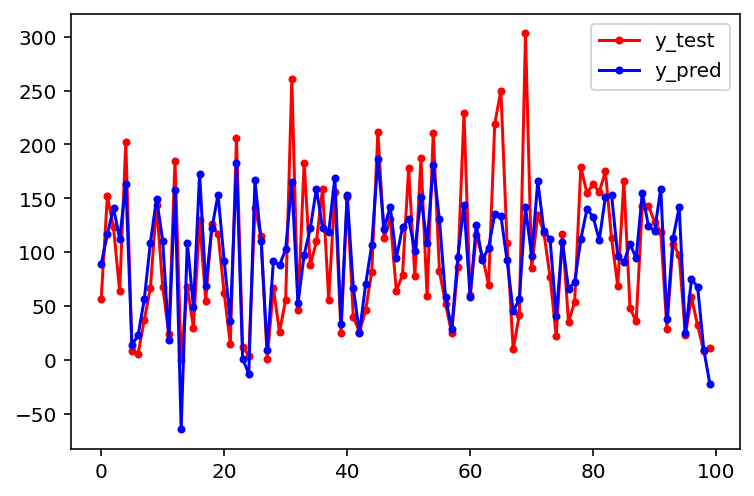

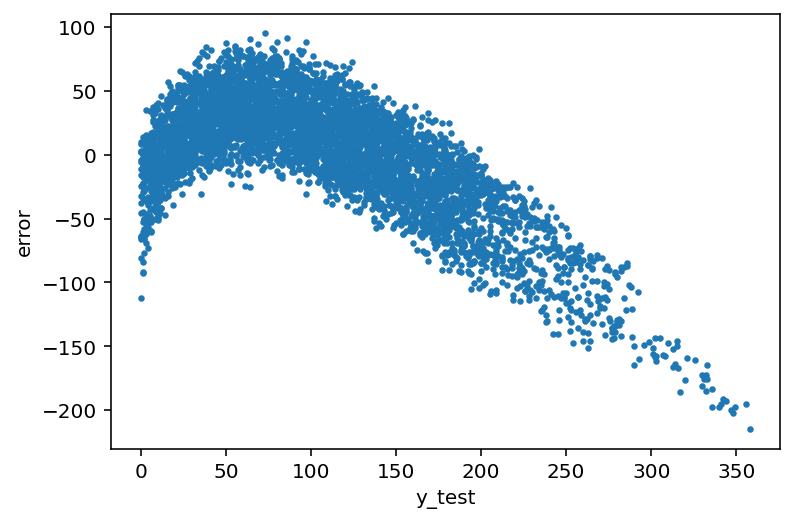

In [114]:
show_regression_result(y_test, y_pred)

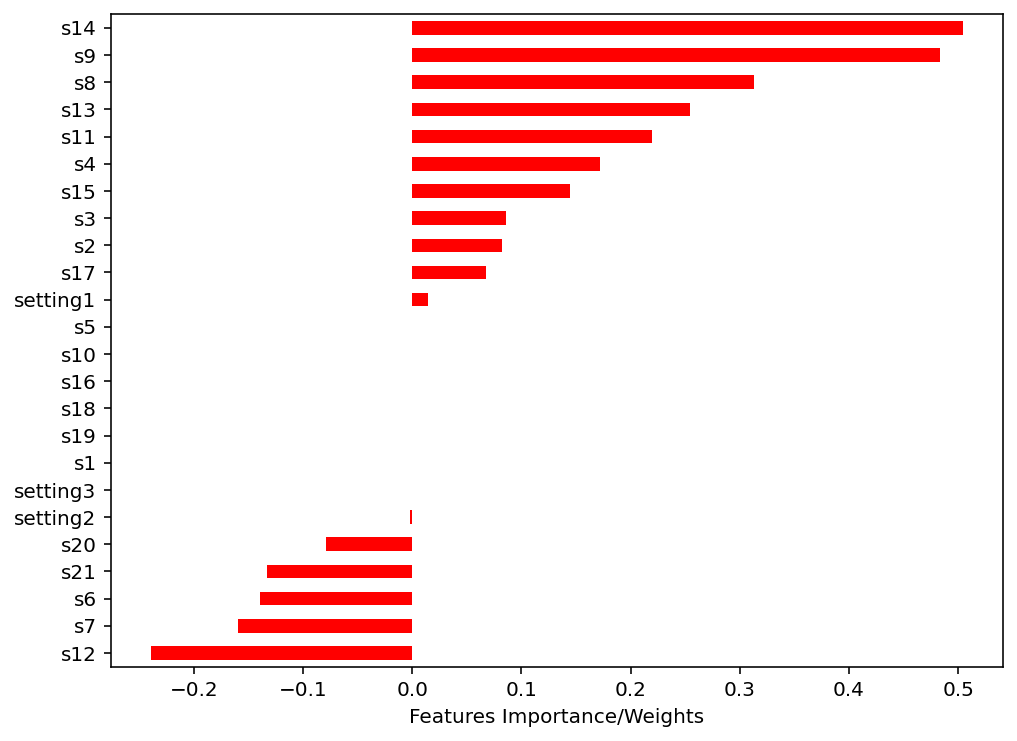

In [90]:
plot_features_weights(X_train.columns, linreg.coef_)

## 랜덤 포레스트

In [115]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

MAE= 29.4674
rmse= 41.3905
max error= 113.54
R2= 0.6353


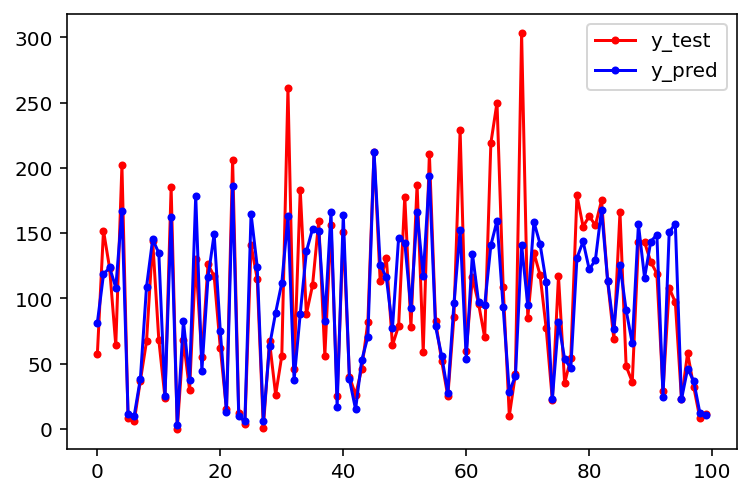

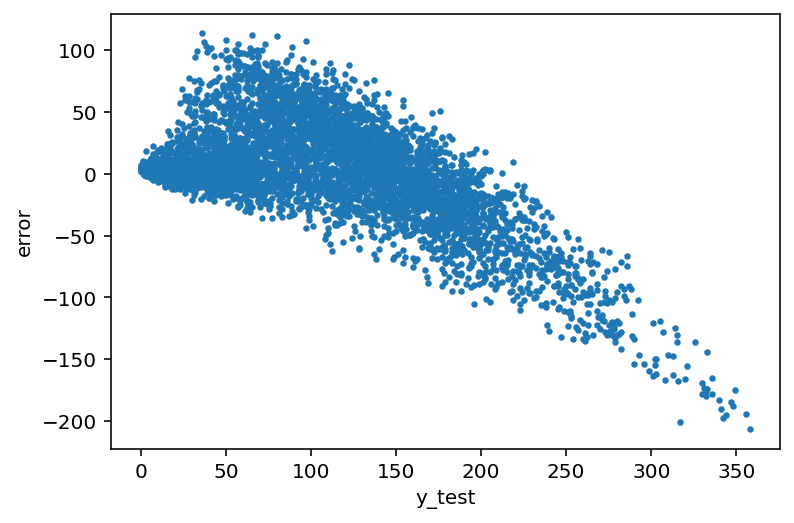

In [116]:
show_regression_result(y_test, y_pred)

In [117]:
np.vstack((y_test, y_pred)).T

array([[ 57.  ,  81.23],
       [152.  , 118.3 ],
       [123.  , 123.69],
       ...,
       [ 24.  ,  92.5 ],
       [257.  , 130.51],
       [ 67.  ,  62.28]])

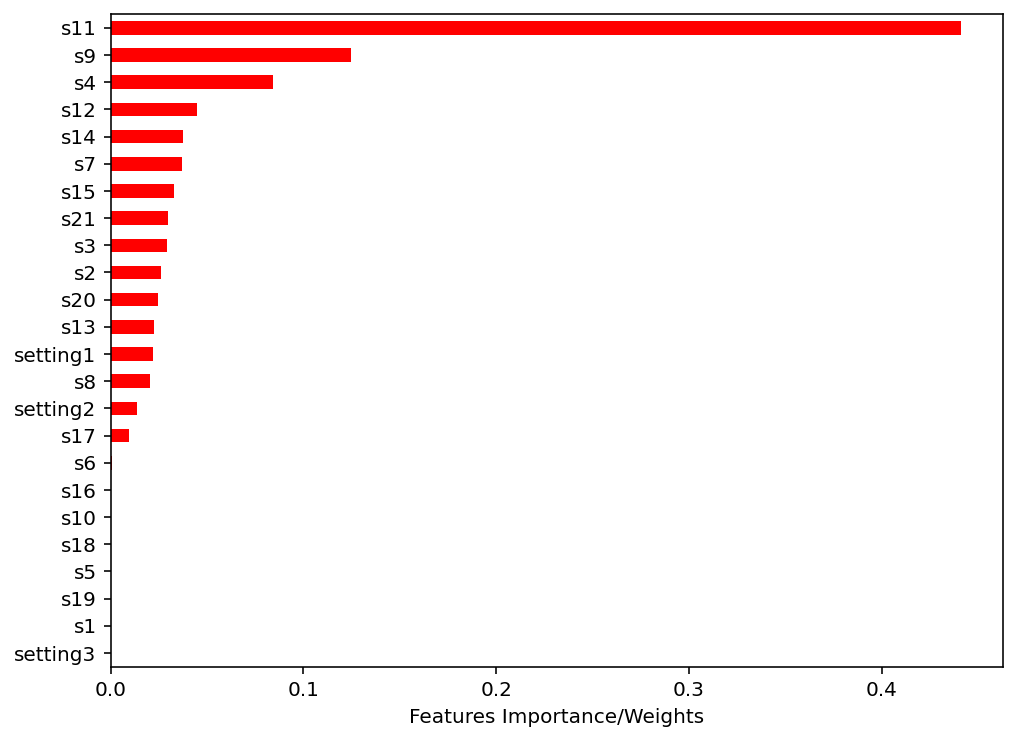

In [118]:
plot_features_weights(X_train.columns, rf.feature_importances_)

# PM 이진 분류

In [119]:
X = df[features]
y = df['label_bnc']

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y)# 학습 및 검증 데이터 크기 확인
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15473, 24), (5158, 24), (15473,), (5158,))

# 로지스틱 회귀

In [142]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

### 컨퓨전 매트릭스
- 정확도, 정밀도, 리콜, f1점수 보기

In [143]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[4286  101]
 [ 123  648]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      4387
           1       0.87      0.84      0.85       771

    accuracy                           0.96      5158
   macro avg       0.92      0.91      0.91      5158
weighted avg       0.96      0.96      0.96      5158



### ROC 커브 그리기

In [144]:
def draw_roc(y_test, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_test.values, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()

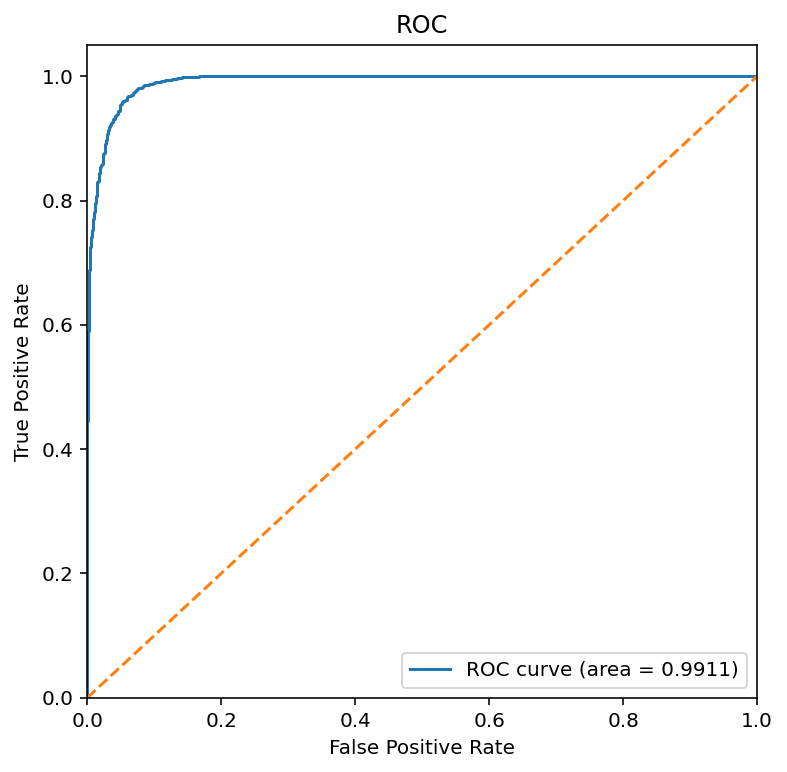

In [69]:
y_score = model.predict_proba(X_test)[:,1]
draw_roc(y_test, y_score)

In [145]:
def draw_PR_curve(y_test, scores):
    prec, rcl, thres = precision_recall_curve(y_test, scores)
    ap = average_precision_score(y_test, scores)
    plt.figure(figsize=(6,6))
    plt.plot(rcl, prec, label='AP = %0.4f)' % ap)
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower right")

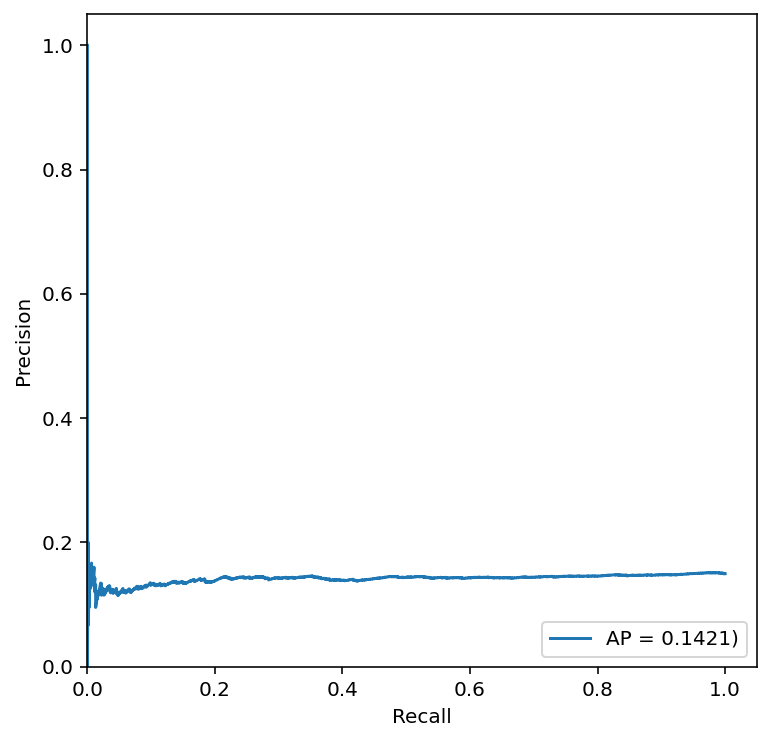

In [146]:
draw_PR_curve(y_test, y_score)

array([0, 1, 0, ..., 0, 0, 0])

# 랜덤 포레스트

In [66]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

In [67]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[4302   75]
 [ 119  662]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4377
           1       0.90      0.85      0.87       781

    accuracy                           0.96      5158
   macro avg       0.94      0.92      0.93      5158
weighted avg       0.96      0.96      0.96      5158



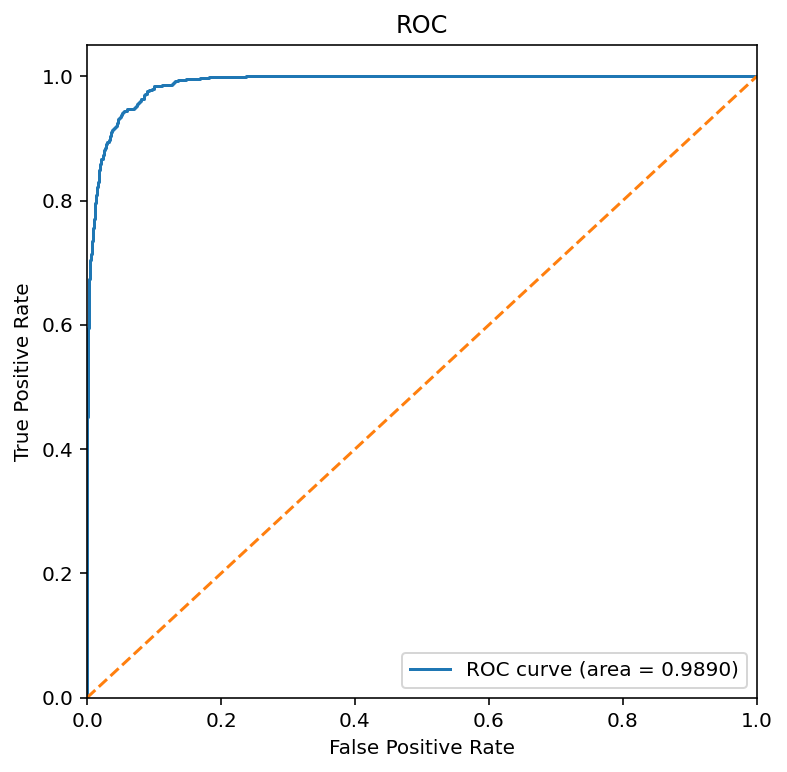

In [57]:
y_score = model.predict_proba(X_test)[:,1]
draw_roc(y_test, y_score)

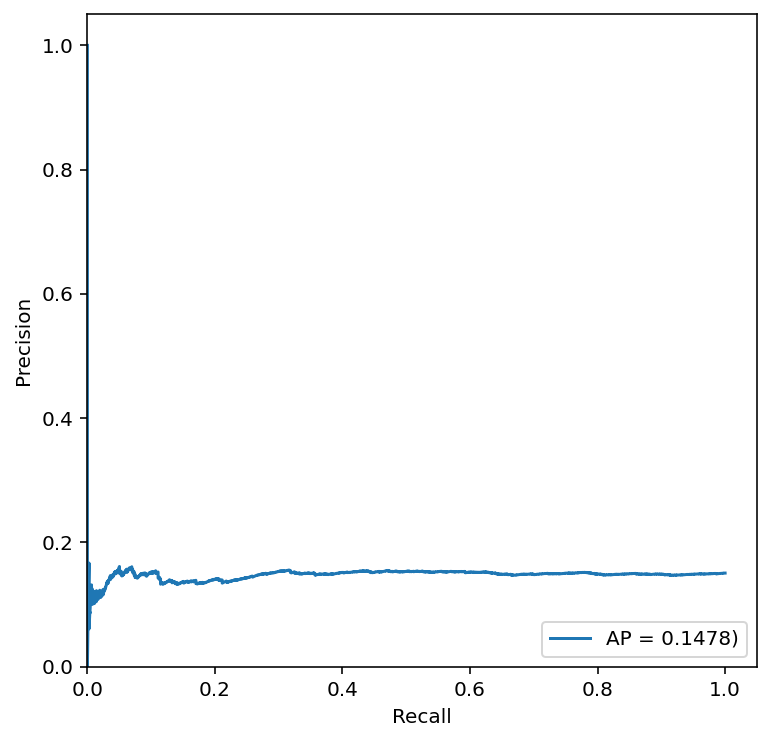

In [133]:
draw_PR_curve(y_test, y_score)

In [132]:
y_pred = model.predict_proba(X_test)[:,1] > 0.5 #기본값으로는 0.5를 기준으로 적부판정. 
y_pred*1

show_clf_result(y_test, model.predict.....)

array([0, 1, 0, ..., 0, 0, 0])

## Discussion
- 이동평균, 이동분산, 피크수 등의 컬럼을 추가하면 성능이 개선된다 (윈도우 크기 적절하게 선택)
- 특성 선택을 통해서 계산량을 줄일 수 있다
 - 경험으로 선택
 - corr이 큰 특성 선택
 - PCA를 사용하여 주성분 수를 줄일 수 있다 (200 --> 20)
- 분류문제로 처리하는 경우, 분류 기준 시점 선택이 중요하다
 - 고객이 요구하는 시점으로 선택
 - 성능이 가장 잘 나오는 시점을 선택 (실험으로 확인) (성능: 정확도, 리콜, 정밀도, f1 점수 등) 

## (참고) 특성 추가

In [59]:
def rolling_average(df, window):
    df_av = df.rolling(window, min_periods=1).mean()
    df_av.columns = [col + "_av" + str(window) for col in df.columns]
    return df_av
def rolling_std(df, window):
    df_std = df.rolling(window, min_periods=1).std().fillna(0)
    df_std.columns = [col + "_std" + str(window) for col in df.columns]
    return df_std

In [60]:
some_features = ['s12', 's7', 's11']
df2 = df[some_features]

In [61]:
add1 = rolling_average(df2, 5); add1

,s12_av5,s7_av5,s11_av5
0,0.633262,0.726248,0.369048
1,0.699360,0.677134,0.375000
2,0.731343,0.688137,0.333333
3,0.770789,0.701288,0.291667
4,0.765885,0.694686,0.284524
...,...,...,...
20626,0.255864,0.282448,0.777381
20627,0.217058,0.273430,0.760714
20628,0.212793,0.238003,0.748810
20629,0.217910,0.195813,0.780952


In [62]:
add2 = rolling_std(df2, 5); add2

,s12_std5,s7_std5,s11_std5
0,0.000000,0.000000,0.000000
1,0.093477,0.069458,0.008418
2,0.086242,0.052683,0.072414
3,0.105746,0.050419,0.102178
4,0.092233,0.046092,0.089918
...,...,...,...
20626,0.098081,0.063322,0.035863
20627,0.051668,0.078107,0.045605
20628,0.042973,0.073206,0.041110
20629,0.040015,0.054911,0.086197


In [63]:
new_df = pd.concat((df[features], add1, add2), axis=1); new_df

,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,...,s18,s19,s20,s21,s12_av5,s7_av5,s11_av5,s12_std5,s7_std5,s11_std5
0,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,1.0,0.726248,...,0.0,0.0,0.713178,0.724662,0.633262,0.726248,0.369048,0.000000,0.000000,0.000000
1,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,1.0,0.628019,...,0.0,0.0,0.666667,0.731014,0.699360,0.677134,0.375000,0.093477,0.069458,0.008418
2,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,1.0,0.710145,...,0.0,0.0,0.627907,0.621375,0.731343,0.688137,0.333333,0.086242,0.052683,0.072414
3,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,1.0,0.740741,...,0.0,0.0,0.573643,0.662386,0.770789,0.701288,0.291667,0.105746,0.050419,0.102178
4,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,1.0,0.668277,...,0.0,0.0,0.589147,0.704502,0.765885,0.694686,0.284524,0.092233,0.046092,0.089918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,0.477011,0.250000,0.0,0.0,0.686747,0.587312,0.782917,0.0,1.0,0.254428,...,0.0,0.0,0.271318,0.109500,0.255864,0.282448,0.777381,0.098081,0.063322,0.035863
20627,0.408046,0.083333,0.0,0.0,0.701807,0.729453,0.866475,0.0,1.0,0.162641,...,0.0,0.0,0.124031,0.366197,0.217058,0.273430,0.760714,0.051668,0.078107,0.045605
20628,0.522989,0.500000,0.0,0.0,0.665663,0.684979,0.775321,0.0,1.0,0.175523,...,0.0,0.0,0.232558,0.053991,0.212793,0.238003,0.748810,0.042973,0.073206,0.041110
20629,0.436782,0.750000,0.0,0.0,0.608434,0.746021,0.747468,0.0,1.0,0.133655,...,0.0,0.0,0.116279,0.234466,0.217910,0.195813,0.780952,0.040015,0.054911,0.086197
